In [1]:
import os
import io
import en_core_web_lg

import pandas as pd 
import tensorflow as tf 
import plotly.express as px
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split

nlp = en_core_web_lg.load()

In [2]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
display(100*df.isnull().sum()/df.shape[0])

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
# delete empty columns
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [6]:
# data cleaning with lemmatization
df["review_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["review_clean"] = df["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df["len_review"] = df["review_clean"].apply(lambda x: len(x))
# label encoding
label = LabelEncoder()
df['target'] = label.fit_transform(df['v1'])

In [7]:
display(100*df.isnull().sum()/df.shape[0])

v1              0.0
v2              0.0
review_clean    0.0
len_review      0.0
target          0.0
dtype: float64

<AxesSubplot: >

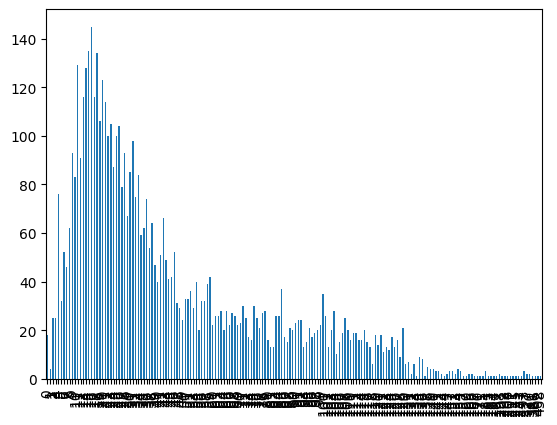

In [8]:
df['len_review'].value_counts().sort_index().plot(kind='bar')

In [9]:
# text-to-digital transformation for computer comprehension
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(df["review_clean"])
df["review_encoded"] = tokenizer.texts_to_sequences(df["review_clean"])

In [10]:
# addition of a pading to have an entry shape in the model which is identical
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df["review_encoded"], padding="post")
# creation of test data and validation
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,df["target"], test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [11]:
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 65 113 470 ...   0   0   0]
 [ 47 108 355 ...   0   0   0]
 [ 18 513 492 ...   0   0   0]
 ...
 [ 10 928 329 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [859  49  13 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int32)


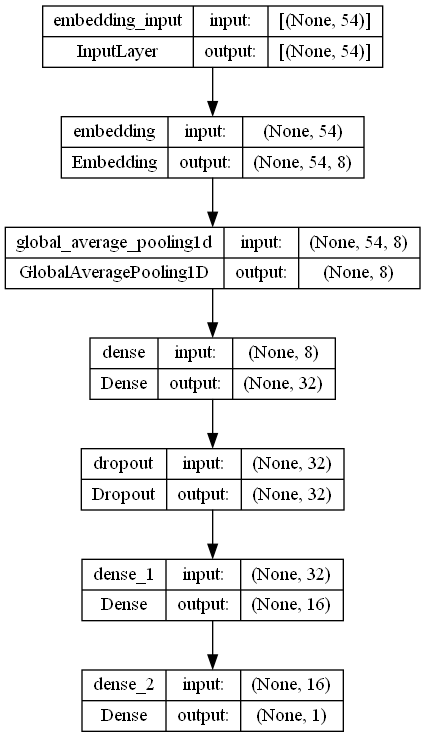

In [12]:
# creation of the model
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([             
            tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),  
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Dense(16, activation='relu'),      
            tf.keras.layers.Dense(1, activation="sigmoid")
                ])

tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
# determination of loss and accuracy calculation data
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [14]:
# visualization of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             65528     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                        

In [15]:
weights = 1/(df["target"]).value_counts()
weights = weights * len(df)/13
weights = {index: values for index,
            values in zip(weights.index, weights.values)}

In [16]:
Checkpoint_create = tf.keras.callbacks.ModelCheckpoint(
                        filepath='model_weights.hdf5',
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        save_freq='epoch',
                        period=1)

In [17]:
# train model
model.fit(train_batch, 
            epochs=20, 
            validation_data=val_batch,
            class_weight=weights,
            callbacks=Checkpoint_create)

Epoch 1/20
43/61 [====================>.........] - ETA: 0s - loss: 0.1076 - accuracy: 0.6944 
Epoch 1: val_loss improved from inf to 0.68896, saving model to model_weights.hdf5
61/61 [==============================] - 1s 4ms/step - loss: 0.1071 - accuracy: 0.7349 - val_loss: 0.6890 - val_accuracy: 0.8720
Epoch 2/20
44/61 [====================>.........] - ETA: 0s - loss: 0.1066 - accuracy: 0.8697
Epoch 2: val_loss improved from 0.68896 to 0.66498, saving model to model_weights.hdf5
61/61 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.8797 - val_loss: 0.6650 - val_accuracy: 0.9354
Epoch 3/20
47/61 [======================>.......] - ETA: 0s - loss: 0.1026 - accuracy: 0.9355
Epoch 3: val_loss improved from 0.66498 to 0.52084, saving model to model_weights.hdf5
61/61 [==============================] - 0s 2ms/step - loss: 0.0996 - accuracy: 0.9397 - val_loss: 0.5208 - val_accuracy: 0.9480
Epoch 4/20
48/61 [======================>.......] - ETA: 0s - loss: 0.077

In [18]:
# accuracy score and loss
history_model = pd.DataFrame(model.history.history)
history_model

,loss,accuracy,val_loss,val_accuracy
0,0.107053,0.734872,0.688958,0.872010
1,0.106095,0.879744,0.664982,0.935407
2,0.099623,0.939744,0.520842,0.947967
3,0.073569,0.965897,0.315781,0.975478
4,0.040665,0.972564,0.150214,0.979067
5,0.026254,0.976154,0.125159,0.976077
6,0.020502,0.976410,0.105701,0.979665
7,0.018333,0.977436,0.066929,0.981459
8,0.013935,0.981795,0.079136,0.982656
9,0.012672,0.984615,0.103423,0.973086


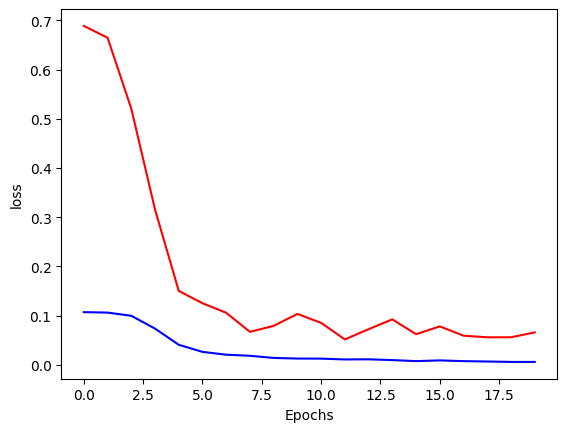

In [19]:
# visualization of the loss
plt.plot(history_model["loss"], color="b")
plt.plot(history_model["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

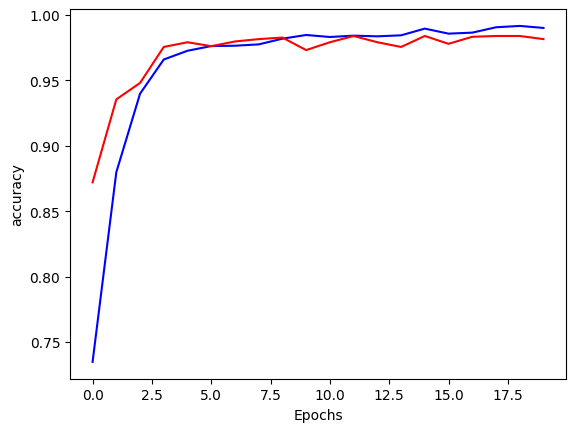

In [20]:
# visualization of accuracy
plt.plot(history_model["accuracy"], color="b")
plt.plot(history_model["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

## test on a model already usable download via tenserflow hub

In [21]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [22]:
label = LabelEncoder()
df['target'] = label.fit_transform(df['v1'])

In [23]:
xtrain, xval, ytrain, yval = train_test_split(df["v2"],df["target"], test_size=0.3)

train_data = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((xval, yval))

In [24]:
# model embedding taken from tenserflow hub
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [25]:
model_hub = tf.keras.Sequential()
model_hub.add(hub_layer)
model_hub.add(tf.keras.layers.Dense(32, activation='selu'))
model.add(tf.keras.layers.Dropout(0.2))
model_hub.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model_hub.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_hub.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,647,361
Trainable params: 124,647,361
Non-trainable params: 0
_________________________________________________________________


In [26]:
weights = 1/(df["target"]).value_counts()
weights = weights * len(df)/13
weights = {index: values for index,
            values in zip(weights.index, weights.values)}

In [27]:
Checkpoint_create = tf.keras.callbacks.ModelCheckpoint(
                        filepath='model_hub_weights.hdf5',
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='auto',
                        save_freq='epoch',
                        period=1)

In [28]:
model_hub.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# train model
model_hub.fit(train_data.shuffle(10000).batch(512),
                epochs=20,
                class_weight=weights,
                validation_data=val_data.batch(512),
                verbose=1,
                callbacks=Checkpoint_create
                )

Epoch 1/20


c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.8769
Epoch 1: val_loss improved from inf to 0.50372, saving model to model_hub_weights.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.0992 - accuracy: 0.8769 - val_loss: 0.5037 - val_accuracy: 0.9300
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9559
Epoch 2: val_loss improved from 0.50372 to 0.37889, saving model to model_hub_weights.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.0761 - accuracy: 0.9559 - val_loss: 0.3789 - val_accuracy: 0.9516
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9662
Epoch 3: val_loss improved from 0.37889 to 0.27410, saving model to model_hub_weights.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.0549 - accuracy: 0.9662 - val_loss: 0.2741 - val_accuracy: 0.9587
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 

In [30]:
history_model_hub = pd.DataFrame(model_hub.history.history)
history_model_hub

,loss,accuracy,val_loss,val_accuracy
0,0.099173,0.876923,0.503721,0.930024
1,0.076136,0.955897,0.378890,0.951555
2,0.054936,0.966154,0.274101,0.958732
3,0.036681,0.972308,0.197212,0.961722
4,0.023240,0.977949,0.154932,0.965311
5,0.014585,0.983846,0.124821,0.966507
6,0.009227,0.989231,0.105794,0.969498
7,0.005936,0.993333,0.096008,0.970694
8,0.004010,0.996154,0.091691,0.972488
9,0.002752,0.997949,0.090087,0.971292


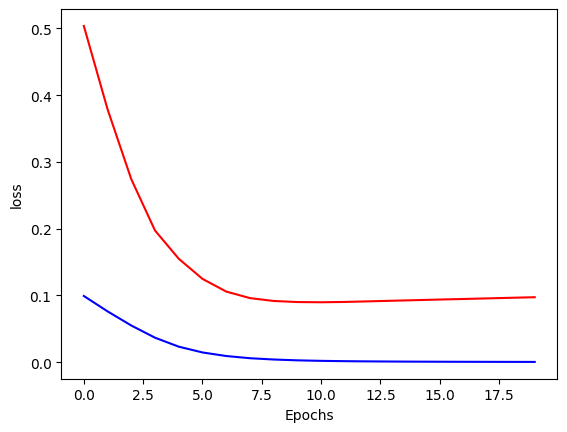

In [31]:
plt.plot(history_model_hub["loss"], color="b")
plt.plot(history_model_hub["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

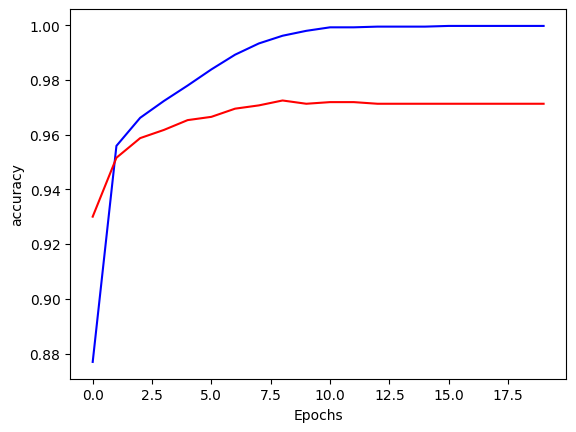

In [32]:
plt.plot(history_model_hub["accuracy"], color="b")
plt.plot(history_model_hub["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()